# Common Spatial Pattern BCI
Date: 2020 Aug 12th
Writer: Orvin Demsy
Description:  

This code is a revision of previous CSP version, revision include:
* Applying band-pass 8-30Hz before 
* Using W = B.T * P 
* Add np.log10 in feature extraction step
* Use sqrtm(inv(X)) when computing white matrix

Same as previous version this will used BCI competition IV IIa dataset and only take left and right class

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dframe = pd.DataFrame

In [3]:
%autosave 5

Autosaving every 5 seconds


# Loading dataset

In [4]:
# Creating dict to store original data and modified data
ori_data = dict()
mod_data = dict()

In [5]:
# Create function to print keys() within dictionary
def showKeys(dict_name):
    print('Keys in this dict are: ')
    for i in dict_name.keys():
        print(i)

In [6]:
# number of subject to be processed (n+1 for iteration purpose)
ns = 10

In [7]:
# Load the training data of all subjects

# Iter over all data path then store them in sub0X variable
for i in range(1, ns):
    data_path = './datasets/A{:02d}T.npz'.format(i)
    subject = 'subject{:02d}'.format(i)
    
    # Load EEG data from datapath and store into subj0X variabel then store into data dictionary
    ori_data[subject] = np.load(data_path)

In [8]:
# function to count subject
def subjectCounter(i):
    return 'subject0{}'.format(i)

In [9]:
# Peek into ori_data type and its keys 
print(type(ori_data['subject01']))
print(ori_data['subject01'].files)

<class 'numpy.lib.npyio.NpzFile'>
['s', 'etyp', 'epos', 'edur', 'artifacts']


In [10]:
ori_data['subject01']['artifacts'].ravel()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1], dtype=uint8)

Explanation regarding contents of the keys inside each subject data:
* **s**: 's' contains continuous time-series recorded EEG signals are, shape of M x N array. Size may vary between subjects but N is fixed to 25, indicates 25 electrodes with 22 first EEG and 3 last EOG
* **etype**: 'etyp' stands for event type which indicate event occurence, event code will be describe in subsequent table
* **epos**: 'epos' stands for event position, denoting corresponding event begins at n-th sample at **'s'**
* **edur**: 'edur' stands for event duration, denoting duration of corresponding event
* **artifacts**: size of 288 x 1, 288 comes form 6 x 48, 6 runs where @run has 48 trials, @class has 12 trials

In [11]:
# ori_data will contain original data that is the raw file
# mod_data will contain modified original data

In [12]:
# Initialize 'subject0x' dict inside mod_data
for i in range(1, ns):
    subj = subjectCounter(i)
    mod_data[subj] = {}
    
mod_data

{'subject01': {},
 'subject02': {},
 'subject03': {},
 'subject04': {},
 'subject05': {},
 'subject06': {},
 'subject07': {},
 'subject08': {},
 'subject09': {}}

In [13]:
# Peek into different shape of recorded data/'s' between subjects
print('Sample\tElectrodes')
for i in range(1, ns):
    subj_temp = subjectCounter(i)
    print(ori_data[subj_temp]['s'].shape)

Sample	Electrodes
(672528, 25)
(677169, 25)
(660530, 25)
(600915, 25)
(686120, 25)
(678980, 25)
(681071, 25)
(675270, 25)
(673328, 25)


In [14]:
# First extract the sample data from ori_data into mod_data
for i in range(1, ns):
    subj = subjectCounter(i)
    mod_data[subj]['raw_EEG'] = ori_data[subj]['s']

In [15]:
# Visualizing sample_data inside subject01
# You can see that it has 25 electrodes stored in columns
pd.DataFrame(mod_data['subject01']['raw_EEG']).head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-21.142578,-23.681641,-21.484375,-25.146484,-25.732422,-27.929688,-14.550781,-22.509766,-25.439453,-28.710938,...,-30.615234,-29.638672,-26.660156,-20.947266,-25.439453,-24.902344,-19.677734,31.738281,-13.671875,-43.945312
1,-21.923828,-23.925781,-24.316406,-25.341797,-26.074219,-25.244141,-16.064453,-22.753906,-28.320312,-29.248047,...,-31.054688,-30.712891,-26.123047,-22.998047,-27.099609,-26.367188,-23.339844,22.460938,-13.183594,-40.527344
2,-15.625000,-19.726562,-18.847656,-21.582031,-20.751953,-21.728516,-12.451172,-20.410156,-23.730469,-25.927734,...,-28.759766,-28.417969,-24.462891,-21.386719,-25.097656,-24.267578,-21.484375,33.691406,-8.300781,-38.574219
3,-16.699219,-13.720703,-20.361328,-20.849609,-24.169922,-22.021484,-10.986328,-16.357422,-25.585938,-24.951172,...,-27.783203,-28.857422,-25.537109,-19.335938,-24.316406,-24.511719,-17.919922,41.992188,-7.324219,-38.574219
4,-19.335938,-17.626953,-20.410156,-26.464844,-27.392578,-29.882812,-9.277344,-18.359375,-24.609375,-30.517578,...,-31.884766,-33.740234,-32.666016,-18.554688,-26.611328,-28.466797,-18.408203,37.109375,-15.136719,-49.804688


# Preprocessing

In [16]:
# Removing last three EOG electrode using np.delete, store data as EEG_only to each subject dict
for i in range(1, ns):
    subj = subjectCounter(i)
    mod_data[subj]['raw_EEG'] = np.delete(mod_data[subj]['raw_EEG'], np.s_[22:], 1)

In [17]:
mod_data['subject01'].keys()

dict_keys(['raw_EEG'])

## Bandpass filtering 8-30 Hz
Using FIR [8 30] Hz band-pass filter to remove muscle artifacts, powerline noise, and DC drift  
The command fir1 in used in MATLAB which is equivalent to scipy.signal.firwin in python  
Next EEG signals between [0.5, 3.5] seconds after cue onset are extracted

In [18]:
from scipy.signal import firwin, freqz, lfilter

In [19]:
# From document freqeuncy sampling at 250 Hz
fs = 250

In [20]:
def fir_bandpass(numtaps, low, high, fs):
    fnyq = fs/2
    b = firwin(numtaps, np.array([low, high])/(fnyq), pass_zero = 'bandpass')
    
    return b 

In [21]:
# This function will apply bandpass filter to raw EEG data
def apply_bandpass(raw_EEG, b):
    '''
    INPUT:
    raw_EEG : EEG data in the shape of S x N
    b : coefficient of band-pass filter
    
    OUTPUT:
    EEG_filtered : filtered EEG data shape S x N
    
    N : number of channel
    S : number of sample
    '''
    raw_EEG = lfilter(b, 1, raw_EEG, axis=0)
    
    return raw_EEG

In [22]:
# Creating band-pass filter
b = fir_bandpass(51, low=8, high=30, fs=fs)

In [23]:
# Applying bandpass

# Key to access data
raw_EEG = 'raw_EEG'

# Key to store result
EEG_filtered = 'EEG_filtered'

for i in range(1, ns):
    subj = subjectCounter(i)
    
    temp_raw_EEG = mod_data[subj][raw_EEG]
    
    mod_data[subj][EEG_filtered] = apply_bandpass(temp_raw_EEG, b)

In [24]:
dframe(mod_data['subject01']['EEG_filtered']).head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-0.020422,-0.022875,-0.020752,-0.024290,-0.024856,-0.026978,-0.014055,-0.021743,-0.024573,-0.027733,...,-0.025186,-0.022356,-0.023960,-0.029572,-0.028629,-0.025752,-0.020234,-0.024573,-0.024054,-0.019007
1,-0.028404,-0.031205,-0.030831,-0.033074,-0.033981,-0.033931,-0.020491,-0.029673,-0.036051,-0.038065,...,-0.031740,-0.030597,-0.034277,-0.040461,-0.039797,-0.034346,-0.029374,-0.034872,-0.033981,-0.029271
2,-0.022534,-0.027174,-0.026464,-0.029447,-0.028894,-0.029548,-0.017482,-0.027437,-0.032539,-0.034971,...,-0.024285,-0.029289,-0.032084,-0.038319,-0.037874,-0.032493,-0.028467,-0.033443,-0.032392,-0.028682
3,-0.027857,-0.027150,-0.032594,-0.035113,-0.038213,-0.037143,-0.019260,-0.029577,-0.040505,-0.041637,...,-0.035856,-0.031609,-0.039735,-0.045916,-0.046540,-0.041085,-0.032311,-0.039749,-0.039492,-0.030589
4,-0.064138,-0.066045,-0.067683,-0.079740,-0.082914,-0.087771,-0.040368,-0.065460,-0.080927,-0.091818,...,-0.087361,-0.067454,-0.079225,-0.097632,-0.098159,-0.089933,-0.064292,-0.082052,-0.082849,-0.061782


## Taking EEG data corresponds  to left and right class
Current method of CSP calculation requires EEG left and EEG right data,  
thus the goal here is to make EEG left and EEG right class each has dimension T x C x N, where  
T = trial, C = channel, N = sample

In [25]:
# First take the position of left and right class
left_pos = 'left_pos'
right_pos = 'right_pos'


for i in range(1, ns):
    subj = subjectCounter(i)
    
    mod_data[subj][left_pos] = ori_data[subj]['epos'][ori_data[subj]['etyp'] == 769]
    mod_data[subj][right_pos] = ori_data[subj]['epos'][ori_data[subj]['etyp'] == 770]

In [26]:
# Now take EEG data within [0.5 3.5] seconds after cue onset position of each class
start = 0.5
end = 3.5

# Key to access data
EEG_filtered = 'EEG_filtered'

# Key to store result
EEG_left = 'EEG_left'
EEG_right = 'EEG_right'

for i in range(1, ns):
    subj = subjectCounter(i)
        
    # Temporary variable of left and right pos    
    temp_pos_left = mod_data[subj][left_pos]
    temp_pos_right = mod_data[subj][right_pos]

    temp_EEG_left = []
    temp_EEG_right = []
    
    # LEFT
    for j in range(len(temp_pos_left)):
        temp_EEG_left.append(mod_data[subj][EEG_filtered]\
                             [temp_pos_left[j] + int(start*fs) : temp_pos_left[j] + int(end*fs)].T)
    
    mod_data[subj][EEG_left] = np.array(temp_EEG_left)
    
    # RIGHT
    for j in range(len(temp_pos_right)):
        temp_EEG_right.append(mod_data[subj][EEG_filtered]\
                              [temp_pos_right[j] + int(start*fs) : temp_pos_right[j] + int(end*fs)].T)
        
    mod_data[subj][EEG_right] = np.array(temp_EEG_right)

In [27]:
dframe(mod_data['subject01']['EEG_right'][-1]).head()

,0,1,2,3,4,5,6,7,8,9,...,740,741,742,743,744,745,746,747,748,749
0,-3.280087,-5.109051,-5.672537,-5.111599,-3.899460,-2.593373,-1.591841,-0.985517,-0.578749,-0.090275,...,-1.772163,-0.085597,1.080908,1.711972,1.949453,1.976977,1.964539,2.014536,2.125415,2.254110
1,-2.547175,-4.302690,-5.309319,-5.470119,-4.832418,-3.556131,-1.878648,-0.117910,1.424508,2.437497,...,-3.521003,-1.265150,0.136607,0.545482,0.184084,-0.502538,-1.020506,-0.986947,-0.281741,0.981587
2,-2.991825,-4.763764,-5.588473,-5.527517,-4.789856,-3.621242,-2.252209,-0.868619,0.400097,1.423731,...,-1.760539,-0.133423,0.715726,0.875251,0.646276,0.361736,0.278000,0.499216,0.961176,1.526529
3,-3.141083,-4.660437,-5.053033,-4.502334,-3.423306,-2.255246,-1.293399,-0.622783,-0.114256,0.372676,...,-0.897646,0.340081,0.821234,0.741936,0.492841,0.444858,0.780600,1.439134,2.130652,2.550930
4,-2.631041,-3.825343,-3.846291,-3.100074,-2.217474,-1.704968,-1.736631,-2.096243,-2.316440,-1.978562,...,-0.552320,0.527479,1.061591,1.233409,1.301396,1.451247,1.730466,2.047716,2.241499,2.211129


In [28]:
# Checking if raw EEG contains NaN
isnan = []
for i in range(1, ns):
    subj = subjectCounter(i)
    temp = np.isnan(mod_data[subj]['raw_EEG'])
    
    isnan.append(np.sum(temp))
    
isnan

[0, 0, 0, 0, 0, 0, 0, 0, 0]

In [29]:
# Checking current size of EEG left and right data
print('\t\tLeft \t\t Right')

for i in range(1, ns):
    
    subj = subjectCounter(i)
    temp = mod_data[subj]
    
    print('subject{:02d}:\t{}\t{}'.format(i, temp['EEG_left'].shape, temp['EEG_right'].shape))

		Left 		 Right
subject01:	(72, 22, 750)	(72, 22, 750)
subject02:	(72, 22, 750)	(72, 22, 750)
subject03:	(72, 22, 750)	(72, 22, 750)
subject04:	(72, 22, 750)	(72, 22, 750)
subject05:	(72, 22, 750)	(72, 22, 750)
subject06:	(72, 22, 750)	(72, 22, 750)
subject07:	(72, 22, 750)	(72, 22, 750)
subject08:	(72, 22, 750)	(72, 22, 750)
subject09:	(72, 22, 750)	(72, 22, 750)


In [30]:
temp = dframe(mod_data['subject01']['EEG_right'][0])

# Split into test and train data

In [31]:
def split_EEG_one_class(EEG_one_class, percent_train=0.8):
    '''
    split_EEG_one_class will receive EEG data of one class, with size of T x N x M, where
    T = number of trial
    N = number of electrodes
    M = sample number
    
    INPUT:
    EEG_data_one_class: the data of one class of EEG data
    
    percent_train: allocation percentage of training data, default is 0.8
    
    OUTPUT:
    EEG_train: EEG data for training
    
    EEG_test: EEG data for test
    
    Both have type of np.arrray dimension of T x M x N
    '''

    # Number of all trials
    n = EEG_one_class.shape[0]
    
    n_tr = round(n*percent_train)
    n_te = n - n_tr
    
    EEG_train = EEG_one_class[:n_tr]
    EEG_test = EEG_one_class[n_tr:n_tr+n_te]
        
    return EEG_train, EEG_test

In [32]:
# Keys to access data
EEG_left = 'EEG_left'
EEG_right = 'EEG_right'

# Keys to store result
EEG_left_train = 'EEG_left_train'
EEG_right_train = 'EEG_right_train'

EEG_left_test = 'EEG_left_test'
EEG_right_test = 'EEG_right_test'

for i in range(1, ns):
    
    subj = subjectCounter(i)
    
    mod_data[subj][EEG_left_train], mod_data[subj][EEG_left_test] = split_EEG_one_class(mod_data[subj][EEG_left], 0.8)
    mod_data[subj][EEG_right_train], mod_data[subj][EEG_right_test] = split_EEG_one_class(mod_data[subj][EEG_right], 0.8)    

In [33]:
# Checking size of EEG left and right data training and test data
print('\t\tLeft \t\t Right')
print('TRAINING')
for i in range(1, ns):
    
    subj = subjectCounter(i)
    temp = mod_data[subj]
    
    print('subject{:02d}:\t{}\t{}'.format(i, temp[EEG_left_train].shape, temp[EEG_right_train].shape))

print('TEST')
for i in range(1, ns):
    
    subj = subjectCounter(i)
    temp = mod_data[subj]
    
    print('subject{:02d}:\t{}\t{}'.format(i, temp[EEG_left_test].shape, temp[EEG_right_test].shape))

		Left 		 Right
TRAINING
subject01:	(58, 22, 750)	(58, 22, 750)
subject02:	(58, 22, 750)	(58, 22, 750)
subject03:	(58, 22, 750)	(58, 22, 750)
subject04:	(58, 22, 750)	(58, 22, 750)
subject05:	(58, 22, 750)	(58, 22, 750)
subject06:	(58, 22, 750)	(58, 22, 750)
subject07:	(58, 22, 750)	(58, 22, 750)
subject08:	(58, 22, 750)	(58, 22, 750)
subject09:	(58, 22, 750)	(58, 22, 750)
TEST
subject01:	(14, 22, 750)	(14, 22, 750)
subject02:	(14, 22, 750)	(14, 22, 750)
subject03:	(14, 22, 750)	(14, 22, 750)
subject04:	(14, 22, 750)	(14, 22, 750)
subject05:	(14, 22, 750)	(14, 22, 750)
subject06:	(14, 22, 750)	(14, 22, 750)
subject07:	(14, 22, 750)	(14, 22, 750)
subject08:	(14, 22, 750)	(14, 22, 750)
subject09:	(14, 22, 750)	(14, 22, 750)


# CSP

In [34]:
# For all subject create new keys to store all result in CSP step
for i in range(1, ns):
    subj = subjectCounter(i)
    
    mod_data[subj]['CSP'] = {}

## Covariance and Composite Covariance

In [36]:
def compute_cov(EEG_data):
    '''
    INPUT:
    EEG_data : EEG_data in shape T x N x S
    
    OUTPUT:
    avg_cov : covariance matrix of averaged over all trials
    '''
    cov = []
    for i in range(EEG_data.shape[0]):
        cov.append(EEG_data[i]@EEG_data[i].T/np.trace(EEG_data[i]@EEG_data[i].T))
        
    cov = np.mean(np.array(cov), 0)
    
    return cov

In [37]:
# Key to access data
EEG_left_train = 'EEG_left_train'
EEG_right_train = 'EEG_right_train'

# Key to store data
CSP = 'CSP'
cov_left = 'cov_left'
cov_right = 'cov_right'
cov_comp = 'cov_comp'

for i in range(1, ns):
    subj = subjectCounter(i)
    
    # New key to store result
    temp_CSP = mod_data[subj][CSP]
    
    # LEFT
    temp_CSP[cov_left] = compute_cov(mod_data[subj][EEG_left_train])

    # RIGHT
    temp_CSP[cov_right] = compute_cov(mod_data[subj][EEG_right_train])
    
    # Add covariance of left and right class as composite covariance
    temp_CSP[cov_comp] = temp_CSP[cov_left] + temp_CSP[cov_right]

In [38]:
temp1 = mod_data['subject03'][CSP][cov_left]
temp2 = mod_data['subject03'][CSP][cov_right]
temp3 = mod_data['subject03'][CSP][cov_comp]

## White Matrix (P)

In [39]:
# Create new keys for result in whitening step
for i in range(1, ns):
    subj = subjectCounter(i)
    
    mod_data[subj]['CSP']['whitening'] = {}

In [40]:
from scipy.linalg import sqrtm
from scipy.linalg import inv

In [41]:
def decompose_cov(avg_cov):
    '''
    This function will decompose average covariance matrix of one class of each subject into 
    eigenvalues denoted by lambda and eigenvector denoted by V
    Both will be in descending order
    
    Parameter:
    avgCov = the averaged covariance of one class
    
    Return:
    λ_dsc and V_dsc, i.e. eigenvalues and eigenvector in descending order
    
    '''
    λ, V = np.linalg.eig(avg_cov)
    λ_dsc = np.sort(λ)[::-1] # Sort eigenvalue descending order, default is ascending order sort
    idx_dsc = np.argsort(λ)[::-1] # Find index in descending order
    V_dsc = V[:, idx_dsc] # Sort eigenvectors descending order
    λ_dsc = np.diag(λ_dsc) # Diagonalize λ_dsc
    
    return λ_dsc, V_dsc

In [42]:
def white_matrix(λ_dsc, V_dsc):
    '''
    '''
    λ_dsc_sqr = sqrtm(inv(λ_dsc))
    P = (λ_dsc_sqr)@(V_dsc.T)
    
    return P

In [43]:
# Keys to access data
whitening = 'whitening'
cov_comp = 'cov_comp'

# Keys to store result
eigval = 'eigval'
eigvec = 'eigvec'
P = 'P'

for i in range(1, ns):
    subj = subjectCounter(i)
    
    temp_whitening = mod_data[subj][CSP][whitening]
    
    temp_cov = mod_data[subj][CSP][cov_comp]
    
    # Decomposing composite covariance into eigenvector and eigenvalue
    temp_whitening[eigval], temp_whitening[eigvec] = decompose_cov(temp_cov)
    
    # White matrix
    temp_whitening[P] = white_matrix(temp_whitening[eigval], temp_whitening[eigvec])

In [44]:
tempP = mod_data['subject01'][CSP][whitening][P]
tempeigval = mod_data['subject01'][CSP][whitening][eigval]
tempeigvec = mod_data['subject01'][CSP][whitening][eigvec]

In [45]:
tempP.shape

(22, 22)

## Common Eigenvec from Sl and Sr
In this step the Sl and Sr will not be stored, will only be used to compute each eigenvector

In [46]:
# Create new keys for result in decomposing Sl and Sr
for i in range(1, ns):
    subj = subjectCounter(i)
    
    mod_data[subj]['CSP']['S_left'] = {}
    mod_data[subj]['CSP']['S_right'] = {}        

In [47]:
def compute_S(avg_Cov, white):
    '''
    This function will compute S matrix, S = P * C * P.T

    INPUT:
    avg_Cov: averaged covariance of one class, dimension N x N, where N is number of electrodes
    white: the whitening transformation matrix
    
    OUTPUT:
    S
    '''
    S = white@avg_Cov@white.T
    
    return S

In [48]:
def decompose_S(S_one_class, order='descending'):
    '''
    This function will decompose the S matrix of one class to get the eigen vector
    Both eigenvector will be the same but in opposite order
    
    i.e the highest eigenvector in S left will be equal to lowest eigenvector in S right matrix 
    '''
    # Decompose S
    λ, B = np.linalg.eig(S_one_class)
    
    # Sort eigenvalues either descending or ascending
    if order == 'ascending':
        idx = λ.argsort() # Use this index to sort eigenvector smallest -> largest
    elif order == 'descending':
        idx = λ.argsort()[::-1] # Use this index to sort eigenvector largest -> smallest
    else:
        print('Wrong order input')
    
    λ = λ[idx]
    B = B[:, idx]
    
    return B, λ 

In [49]:
# Keys to access data
P = 'P'
cov_left = 'cov_left'
cov_right = 'cov_right'
CSP = 'CSP'

# Keys to store data
S_left = 'S_left'
S_right = 'S_right'
eigvec = 'eigvec'
eigval = 'eigval'

for i in range(1, ns):
    subj = subjectCounter(i)
    
    # Where to access data
    temp_P = mod_data[subj][CSP][whitening][P]
    Cl = mod_data[subj][CSP][cov_left]
    Cr = mod_data[subj][CSP][cov_right]
    
    # Where to store result
    temp_Sl = mod_data[subj][CSP][S_left]
    temp_Sr = mod_data[subj][CSP][S_right]

    # LEFT
    Sl = compute_S(Cl, temp_P)
    temp_Sl[eigvec], temp_Sl[eigval] = decompose_S(Sl, 'descending')
    
    # RIGHT
    Sr = compute_S(Cr, temp_P)
    temp_Sr[eigvec], temp_Sr[eigval] = decompose_S(Sr, 'ascending')   

In [50]:
# Checking eigenvalues
temp1 = mod_data['subject05'][CSP][S_left]['eigval']
temp2 = mod_data['subject05'][CSP][S_right]['eigval']

In [51]:
temp1 + temp2

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])

In [52]:
# Checking eigenvector
temp1 = mod_data['subject05'][CSP][S_left]['eigvec']
temp2 = mod_data['subject05'][CSP][S_right]['eigvec']

In [53]:
dframe(temp1).head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.034337,-0.274925,0.018084,0.113816,0.039164,-0.195245,0.276451,-0.131420,0.095024,-0.365595,...,0.004114,-0.316165,-0.160454,-0.056422,-0.235143,0.025086,0.519633,-0.030565,0.070294,-0.069894
1,-0.104875,-0.032112,0.104122,0.080557,-0.208968,0.229181,0.269978,0.124068,-0.015836,-0.057588,...,0.107342,-0.047098,-0.115680,-0.090030,0.518725,-0.369035,-0.244437,-0.242531,-0.151809,-0.080475
2,0.120334,-0.142576,-0.123378,-0.119650,0.037941,0.269308,0.092294,-0.222557,-0.203056,0.152577,...,0.159274,0.244363,0.205827,-0.032077,0.205215,0.032955,0.264689,0.253524,0.295630,-0.546305
3,0.127787,0.559799,-0.045335,-0.087937,-0.241207,0.152786,0.093145,0.239154,-0.016404,0.023806,...,-0.016499,0.225648,0.083725,0.119577,-0.364421,0.105362,0.127887,-0.373712,0.211826,-0.070774
4,-0.583685,-0.079217,0.054737,0.059975,-0.010330,0.337588,0.021809,0.260570,0.311055,0.110553,...,0.285020,-0.064470,0.004414,-0.108865,-0.219486,0.073666,0.223155,-0.064999,-0.214659,-0.167897


In [54]:
dframe(temp2).head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-0.034337,-0.274925,0.018084,0.113816,0.039164,-0.195245,0.276451,-0.131420,0.095024,-0.365595,...,0.004114,-0.316165,-0.160454,-0.056422,-0.235143,0.025086,0.519633,-0.030565,0.070294,0.069894
1,0.104875,-0.032112,0.104122,0.080557,-0.208968,0.229181,0.269978,0.124068,-0.015836,-0.057588,...,0.107342,-0.047098,-0.115680,-0.090030,0.518725,-0.369035,-0.244437,-0.242531,-0.151809,0.080475
2,-0.120334,-0.142576,-0.123378,-0.119650,0.037941,0.269308,0.092294,-0.222557,-0.203056,0.152577,...,0.159274,0.244363,0.205827,-0.032077,0.205215,0.032955,0.264689,0.253524,0.295630,0.546305
3,-0.127787,0.559799,-0.045335,-0.087937,-0.241207,0.152786,0.093145,0.239154,-0.016404,0.023806,...,-0.016499,0.225648,0.083725,0.119577,-0.364421,0.105362,0.127887,-0.373712,0.211826,0.070774
4,0.583685,-0.079217,0.054737,0.059975,-0.010330,0.337588,0.021809,0.260570,0.311055,0.110553,...,0.285020,-0.064470,0.004414,-0.108865,-0.219486,0.073666,0.223155,-0.064999,-0.214659,0.167897


## Spatial Filter (W)

In [55]:
def spatial_filter(B, P):
    '''
    Will compute projection matrix using the following equation:
    W = B' @ P
    
    INPUT:
    B: the eigenvector either left or right class, choose one, size N x N, N is number of electrodes
    P: white matrix in size of N x N 
    
    OUTPUT:
    W spatial filter to filter EEG
    '''
    
    return (B.T@P)

In [56]:
# Key to access data
CSP = 'CSP'
eigvec = 'eigvec'
S_left = 'S_right'
P = 'P'

# Key to store variable
W = 'W'

for i in range(1, ns):
    subj = subjectCounter(i)
    
    temp_eigvec = mod_data[subj][CSP][S_left][eigvec]
    temp_P = mod_data[subj][CSP][whitening][P]
    
    mod_data[subj][CSP][W] = spatial_filter(temp_eigvec, temp_P)

In [57]:
temp = mod_data['subject01'][CSP][W]

In [58]:
dframe(temp).head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,-0.239296,0.462506,-1.043150,-2.249543,0.371913,0.205224,1.268590,3.171638,13.385910,1.462306,...,-0.028542,-8.645908,-18.374046,2.587676,2.333038,1.267433,7.946352,1.410562,-1.748744,-0.990233
1,1.598296,-8.562549,0.527477,-2.396045,-0.126731,0.333898,-6.560346,23.591195,5.045960,-6.706237,...,0.664940,-0.725840,-9.853490,-0.195212,0.676024,1.916427,-4.936273,5.639671,-2.293612,0.420784
2,-1.507999,-2.137315,12.414533,-7.762040,6.652715,-1.903582,2.985691,9.558595,-25.506480,9.277136,...,0.923863,2.334684,-4.772428,-3.249354,1.749295,6.002303,-5.682335,16.738734,-11.851948,0.627884
3,2.148876,-1.324807,6.214181,-5.832079,-3.060560,5.267160,-2.556745,-0.916345,-11.749503,2.648002,...,-0.058330,5.699912,15.540547,0.484365,-1.584218,3.963987,-18.757887,3.231591,-3.681772,5.861262
4,0.390341,4.904491,-8.471209,6.075540,3.375504,-3.852752,6.461842,-3.808187,-4.553312,-5.072799,...,-1.680322,-6.517700,21.676512,3.659052,2.432170,-6.942282,-5.498651,-13.744784,10.434427,1.164731


# Feature Vector Train

In [59]:
# Create new keys for trainning and test feature vector
for i in range(1, ns):
    subj = subjectCounter(i)
    
    mod_data[subj]['train']= {}
    mod_data[subj]['test']= {}       

In [60]:
# Select number of filter
m = 2

In [61]:
def compute_Z(W, E, m):
    '''
    Will compute the Z
    Z = W @ E, 
    
    E is in the shape of N x M, N is number of electrodes, M is sample
    In application, E has nth trial, so there will be n numbers of Z
    
    Z, in each trial will have dimension of m x M, 
    where m is the first and last m rows of W, corresponds to smallest and largest eigenvalues
    '''
    Z = []
    
    W = np.delete(W, np.s_[m:-m:], 0)
    
    for i in range(E.shape[0]):
        Z.append(W @ E[i])
    
    return np.array(Z)

In [62]:
def feat_vector(Z):
    '''
    Will compute the feature vector of Z matrix
    
    INPUT:
    Z : projected EEG shape of T x N x S
    
    OUTPUT:
    feat : feature vector shape of T x m
    
    T = trial
    N = channel
    S = sample
    m = number of filter
    '''
    
    feat = []
    
    for i in range(Z.shape[0]):
        var = np.var(Z[i], ddof=1, axis=1)
        varsum = np.sum(var)
        
        feat.append(np.log10(var/varsum))
        
    return np.array(feat)

In [63]:
# Where to access data
EEG_left_train = 'EEG_left_train'
EEG_right_train = 'EEG_right_train'
W = 'W'

# Where to store data
train = 'train'
Z_left = 'Z_left'
Z_right = 'Z_right'
feat_left = 'feat_left'
feat_right = 'feat_right'

for i in range(1, ns):
    subj = subjectCounter(i)
    
    temp_W = mod_data[subj][CSP][W]
    temp_EEG_left = mod_data[subj][EEG_left_train]
    temp_EEG_right = mod_data[subj][EEG_right_train]
    
    # LEFT
    mod_data[subj][train][Z_left] = compute_Z(temp_W, temp_EEG_left, m)
    mod_data[subj][train][feat_left] = feat_vector(mod_data[subj][train][Z_left])

    
    # RIGHT
    mod_data[subj][train][Z_right] = compute_Z(temp_W, temp_EEG_right, m)
    mod_data[subj][train][feat_right] = feat_vector(mod_data[subj][train][Z_right])

## True label for each class

In [64]:
# Key to access data
train = 'train'
feat_left = 'feat_left'
feat_right = 'feat_right'

# Key to store data
feat_train = 'feat_train'

for i in range(1, ns):
    subj = subjectCounter(i)
    
    temp_feat_left = mod_data[subj][train][feat_left]
    temp_feat_right = mod_data[subj][train][feat_right]
    
    left_label = np.ones([len(temp_feat_left), 1])*-1
    right_label = np.ones([len(temp_feat_right), 1])    
    
    left  = np.concatenate([temp_feat_left, left_label], axis=1)
    right  = np.concatenate([temp_feat_right, right_label], axis=1)    
    
    mod_data[subj][train][feat_train] = np.vstack([left, right])
    
    np.random.shuffle(mod_data[subj][train][feat_train])

In [65]:
dframe(mod_data[subj][train][feat_train]).head()

,0,1,2,3,4
0,-0.487668,-0.344725,-0.788350,-1.223858,-1.0
1,-0.703536,-0.776090,-0.575813,-0.432906,1.0
2,-0.618249,-0.656897,-0.696321,-0.471624,1.0
3,-0.894126,-0.949117,-0.537532,-0.327980,1.0
4,-0.523900,-0.833503,-0.760054,-0.419961,1.0


# Feature Vector Test

In [93]:
# Where to access data
EEG_left_test = 'EEG_left_test'
EEG_right_test = 'EEG_right_test'
W = 'W'

# Where to store data
test = 'test'
feat_test = 'feat_test'
Z_left = 'Z_left'
Z_right = 'Z_right'
feat_left = 'feat_left'
feat_right = 'feat_right'

for i in range(1, ns):
    subj = subjectCounter(i)
    
    temp_W = mod_data[subj][CSP][W]
    temp_EEG_left = mod_data[subj][EEG_left_test]
    temp_EEG_right = mod_data[subj][EEG_right_test]
    
    # LEFT
    mod_data[subj][test][Z_left] = compute_Z(temp_W, temp_EEG_left, m)
    mod_data[subj][test][feat_left] = feat_vector(mod_data[subj][test][Z_left])
    temp_feat_left = mod_data[subj][test][feat_left]
    
    # RIGHT
    mod_data[subj][test][Z_right] = compute_Z(temp_W, temp_EEG_right, m)
    mod_data[subj][test][feat_right] = feat_vector(mod_data[subj][test][Z_right])
    temp_feat_right = mod_data[subj][test][feat_right]
    
    
    # True label for test data
    left_label = np.ones([len(temp_feat_left), 1])*-1
    right_label = np.ones([len(temp_feat_left), 1])
    
    
    # LEFT + RIGHT
    mod_data[subj][test][feat_test] = np.vstack([np.c_[temp_feat_left, left_label], np.c_[temp_feat_right, right_label]])
    
    np.random.shuffle(mod_data[subj][test][feat_test])

In [94]:
dframe(mod_data[subj][test][feat_test]).head()

,0,1,2,3,4
0,-0.768477,-0.674261,-0.514459,-0.505850,1.0
1,-0.498002,-0.425992,-0.727665,-0.920377,-1.0
2,-0.416546,-0.374797,-0.886235,-1.187523,-1.0
3,-0.771616,-0.767140,-0.489748,-0.473559,1.0
4,-0.467475,-0.584639,-0.668011,-0.734780,-1.0


# Classifying

## Using SVM as Classifier

In [108]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold

In [99]:
# Define model
model = SVC()

In [118]:
model.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

## Evaluate Model Performace on Train Data

In [196]:
# Iterate over each subject
model_acc = []
model_std = []

for i in range(1, ns):
    subj = subjectCounter(i)
    
    print('Processing for {}'.format(subj))
    X_train = mod_data[subj]['train']['feat_train'][:, :-1]
    y_train = mod_data[subj]['train']['feat_train'][:, -1]
    
    model_acc.append(cross_val_score(model, X_train, y_train).mean()*100)
    model_std.append(cross_val_score(model, X_train, y_train).std()*100)

Processing for subject01
Processing for subject02
Processing for subject03
Processing for subject04
Processing for subject05
Processing for subject06
Processing for subject07
Processing for subject08
Processing for subject09


In [188]:
# Necessary variable to label x axis
subject=[]
for i in range(1, ns):
    subject.append(subjectCounter(i))

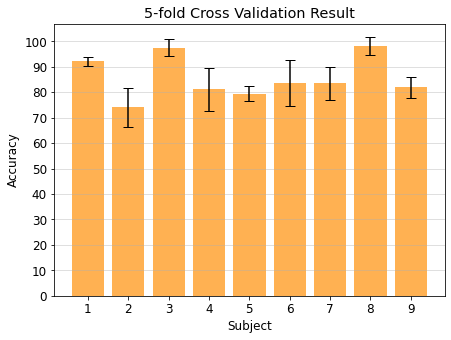

In [206]:
fig, ax = plt.subplots(figsize=(7, 5))
plt.rcParams.update({'font.size': 12})
ax.set_title('Accuracy (%)')
ax.bar(np.arange(1, 10), model_acc, color="#ffb152", yerr=model_std, capsize=5)
ax.set(xticks=np.arange(1, 10), xlabel='Subject', 
       yticks=np.arange(0, 101, step=10), ylabel='Accuracy',
       title='5-fold Cross Validation Result')
ax.grid(axis='y', alpha=0.5)
plt.savefig('5fold_train_result.jpg')
plt.show()

## Result on Test Data
20200930 Currently working under progress, need to know how to evaluate on test data correctly

In [100]:
# Key to access data
train = 'train'
feat_train = 'feat_train'
feat_test = 'feat_test'

# Blank list to store accuracy values
acc_train = []
acc_test = []

for i in range(1, ns):
    subj = subjectCounter(i)
    
    data_train = mod_data[subj][train][feat_train]
    X_train = data_train[:, :-1]
    y_train = data_train[:, -1]
    
    data_test = mod_data[subj][test][feat_test]
    X_test = data_test[:, :-1]
    y_test = data_test[:, -1]
    
    # Fit into model
    model.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    acc_train.append(accuracy_score(y_true=y_train, y_pred=pred_train)*100)
    acc_test.append(accuracy_score(y_true=y_test, y_pred=pred_test)*100)